# EDX Quantification using Partial Ionization Cross Section

This is a personal workbook used to process my own data but has been made public for the use of others. If you find any errors or need further help using this workbook please contact k8macarthur@gmail.com.

## Author

Katherine E. MacArthur - Originally written for EMC2016, 28.08.2016

## Requirements

In order to use the EDX Cross Section quantification a Hyperspy version 1.1 or later is required.

## 1. Importing Hyperspy and Libraries

Being by importing the Hyperspy Function Library.

In [26]:
import matplotlib
matplotlib.rcParams["backend"] = 'Qt4Agg'
import hyperspy.api as hs
import numpy as np
%matplotlib qt4

For inline displaying of figures (optional).

In [27]:
%matplotlib inline

## 2. Importing and Calibrating the Experimental Data

Opens a load window. Use hs.load('filename') if filename is known specifically.

In [28]:
s = hs.load()
s

<EDSTEMSpectrum, title: Original Data Wedge, dimensions: (1024, 64|1024)>

These next two lines are needed for .bcf files from Bruker/Espirit as the imported data comes as a list containing both the ADF image and EDX spectral data cube.

In [4]:
image = s[0]
s = s[1]
s

TypeError: 'EDSTEMSpectrum' object does not support indexing

In [29]:
s.set_signal_type('EDS_TEM')
s.metadata.General.title = 'Original Data Cube'
s.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 45.0
│       │       ├── detector_type = SuperX
│       │       ├── elevation_angle = 18.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 1
│       │       └── real_time = 0.002696
│       ├── beam_current = 0.039
│       ├── beam_energy = 200.0
│       ├── stage_x = None
│       ├── stage_y = None
│       └── tilt_stage = 0.0
├── General
│   ├── original_filename = Pt01-compressed.bcf
│   └── title = Original Data Cube
├── Sample
│   ├── elements = ['Pt']
│   ├── name = Image 1975
│   └── xray_lines = ['Pt_La']
└── Signal
    ├── binned = True
    └── signal_type = EDS_TEM

Adjust the metadata for all the microscope parameters.

In [30]:
s.set_microscope_parameters(beam_energy = 200)
s.set_microscope_parameters(live_time = 1)
s.set_microscope_parameters(real_time = 0.0136535) #dwell time per pixel
s.set_microscope_parameters(beam_current = 0.068) #in nA?
s.isig[50:]

#Or open a GUI using s.set_microscope_parameters(). or hs.preferences.gui()

<EDSTEMSpectrum, title: Original Data Cube, dimensions: (1024, 64|974)>

In [31]:
s.axes_manager[0].name = 'x'
s.axes_manager[1].name = 'y'
s.axes_manager

<Axes manager, axes: (1024, 64|1024)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |   1024 |      0 |       0 |      18 |     nm 
               y |     64 |      0 | 9.7e+03 |      18 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
          Energy |   1024 |        |   -0.23 |    0.01 |    keV

Opens three windows to edit the scale and offset of each axis including the EDX Energy axis.

In [32]:
s.axes_manager.gui()
#s.get_calibration_from(s1pixel) will take all the calibration 

Again the following line  is needed for bcf to chech the ADF image details.

In [8]:
image.axes_manager.gui()

NameError: name 'image' is not defined

Plotting both the image and the spectrum to see that they are imported correctly.

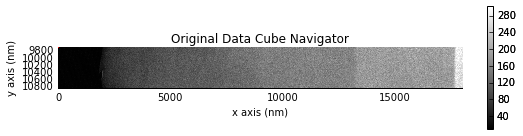

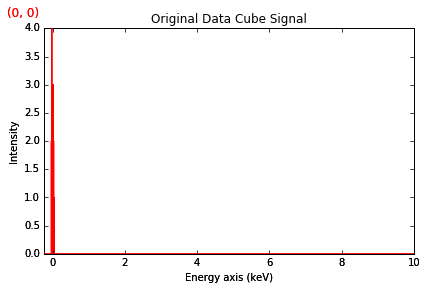

In [33]:
s.plot()
#image.plot()

Setting the elements to be used for quantification. Make sure that these match those used for calibration samples.

In [34]:
s.set_elements(['Pt','Ni'])
s.set_lines(['Pt_La', 'Ni_Ka'])
s.metadata.Sample

├── elements = ['Ni', 'Pt']
├── name = Image 1975
└── xray_lines = ['Ni_Ka', 'Pt_La']

## 3. Importing the Cross Sections Library and Checking Backround and Integration Windows

Import the calibration files of EDX cross sections for the correct microscope.

More details on how to make these files are inluded in the workbook entitled: 'Wedge Analysis - EDX Cross Sections .ipynb'.

In [35]:
cal = hs.load()
calibration = cal.metadata.calibration

Check which elements are included within the calbration file.

In [36]:
calibration.keys()

['Ni', 'Pt']

Extract the calibration information for each element, required for quantification.

In [37]:
cal_Ni = calibration['Ni']
cal_Pt = calibration['Pt']
cal_Ni

├── Background windows = array([[ 6.61175942,  6.75614952,  7.76688019,  7.91127029]])
├── Integration windows = [[7.333709903386694, 7.622490096613307]]
└── cross_section = 3.9401988495054874

Create the integration windows, background windows and cross section list in a format which the intensity extraction function can use.

In [38]:
iw = cal_Ni['Integration windows'] + cal_Pt['Integration windows']
iw

[[7.333709903386694, 7.622490096613307], [9.281605451805987, 9.65]]

In [39]:
bw = np.append(cal_Ni['Background windows'], 
               cal_Pt['Background windows'],
              axis=0)
bw[0][2] = bw[1][0]
bw[0][3] = bw[1][1]
bw

array([[ 6.61175942,  6.75614952,  8.47913271,  8.63962726],
       [ 8.47913271,  8.63962726,  9.7630891 ,  9.92358364]])

In [40]:
cs = cal_Ni['cross_section'],cal_Pt['cross_section']
cs

(3.9401988495054874, 1.685980516055914)

Check that the background windows and integration windows still work on the experimental data. As the calibration samples are single element, they may have selected windows which overlap with other elemental peaks which are in the final experimental data. 

*If you do need to change bw and iw here, it is advised to repeat the wedge calibration workbook so that both sets of integration windows match completely. Background windows are less critical but integration windows should be kept the same between calibration and experiment.*

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


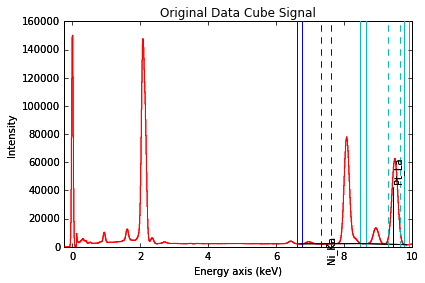

In [41]:
s.sum().plot(True, background_windows=bw, integration_windows=iw)

## 4. Quantifying the Experimental Data, using s.quantification()

If the spectrum requires binnning, it is better to do this now before extracting the intensities.

I normally use the non-integer binning method with linearly interpolates between pixels, and allows conversion of pixel size to any size in the range. The most realistic approach is to fit the pixel size such that one pixel is ~1 atomic column.

Begin by setting the scale function for each dimension in the spectrum data. A bin scale of 1 is required for any dimensions where no binning is wanted. 

In [42]:
scale = [11.25, 11.25, 1]

In [21]:
linear_bin(s.data, scale)

NameError: name 'linear_bin' is not defined

In [45]:
s.change_dtype('float')
inten = s.get_lines_intensity(background_windows=bw, integration_windows=iw)

In [46]:
p = s.quantification(inten, 'cross_section', cs)

Subsequent processing and image plotting and of the resulting data. *To be completed in the future.* 

NB: Anything below this point is still work in progress.

In [47]:
Total = p[1][0] + p[1][1]

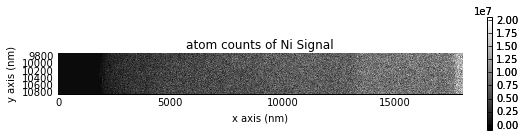

In [48]:
Total.plot()

In [51]:
for i in Total:
    for y in i:
        if y <= 0.4:
            Total[i][y] = 0

Total.plot()

TypeError: 'Signal2D' object is not subscriptable